In [1]:
import os

import pandas
import numpy as np
import seaborn as sb
%matplotlib inline
import matplotlib.pyplot as plt

## Pré-processamento

In [2]:
'''
input_cols = ['NO_MUNICIPIO_RESIDENCIA', 'SG_UF_RESIDENCIA', 'NU_IDADE', 'TP_SEXO', 'TP_ESTADO_CIVIL',
    'TP_COR_RACA', 'TP_NACIONALIDADE', 'NO_MUNICIPIO_NASCIMENTO', 'SG_UF_NASCIMENTO', 'TP_ST_CONCLUSAO',
    'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'TP_ENSINO', 'IN_TREINEIRO', 'NO_MUNICIPIO_ESC',
    'SG_UF_ESC', 'TP_DEPENDENCIA_ADM_ESC', 'TP_LOCALIZACAO_ESC', 'TP_SIT_FUNC_ESC', 'IN_BAIXA_VISAO',
    'IN_CEGUEIRA', 'IN_SURDEZ', 'IN_DEFICIENCIA_AUDITIVA', 'IN_SURDO_CEGUEIRA', 'IN_DEFICIENCIA_FISICA',
    'IN_DEFICIENCIA_MENTAL', 'IN_DEFICIT_ATENCAO', 'IN_DISLEXIA', 'IN_DISCALCULIA', 'IN_AUTISMO',
    'IN_VISAO_MONOCULAR', 'IN_OUTRA_DEF', 'IN_GESTANTE', 'IN_LACTANTE', 'IN_IDOSO', 'IN_ESTUDA_CLASSE_HOSPITALAR',
    'IN_SEM_RECURSO', 'IN_BRAILLE', 'IN_AMPLIADA_24', 'IN_AMPLIADA_18', 'IN_LEDOR', 'IN_ACESSO', 'IN_TRANSCRICAO',
    'IN_LIBRAS', 'IN_LEITURA_LABIAL', 'IN_MESA_CADEIRA_RODAS', 'IN_MESA_CADEIRA_SEPARADA', 'IN_APOIO_PERNA',
    'IN_GUIA_INTERPRETE', 'IN_COMPUTADOR', 'IN_CADEIRA_ESPECIAL', 'IN_CADEIRA_CANHOTO', 'IN_CADEIRA_ACOLCHOADA',
    'IN_PROVA_DEITADO', 'IN_MOBILIARIO_OBESO', 'IN_LAMINA_OVERLAY', 'IN_PROTETOR_AURICULAR', 'IN_MEDIDOR_GLICOSE',
    'IN_MAQUINA_BRAILE', 'IN_SOROBAN', 'IN_MARCA_PASSO', 'IN_SONDA', 'IN_MEDICAMENTOS', 'IN_SALA_INDIVIDUAL', 'IN_SALA_ESPECIAL',
    'IN_SALA_ACOMPANHANTE', 'IN_MOBILIARIO_ESPECIFICO', 'IN_MATERIAL_ESPECIFICO', 'IN_NOME_SOCIAL', 'NO_MUNICIPIO_PROVA',
    'SG_UF_PROVA', 'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT',
    'TP_LINGUA',  'Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006', 'Q007', 'Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013', 'Q014',
    'Q015', 'Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024', 'Q025', 'Q026', 'Q027']
'''
input_cols = ['SG_UF_RESIDENCIA', 'NU_IDADE', 'TP_SEXO', 'TP_ESTADO_CIVIL',
    'TP_COR_RACA', 'TP_NACIONALIDADE', 'SG_UF_NASCIMENTO', 'NO_MUNICIPIO_NASCIMENTO', 'TP_ST_CONCLUSAO',
    'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'TP_ENSINO', 'IN_TREINEIRO',
    'IN_BAIXA_VISAO',
    'IN_CEGUEIRA', 'IN_SURDEZ', 'IN_DEFICIENCIA_AUDITIVA', 'IN_SURDO_CEGUEIRA', 'IN_DEFICIENCIA_FISICA',
    'IN_DEFICIENCIA_MENTAL', 'IN_DEFICIT_ATENCAO', 'IN_DISLEXIA', 'IN_DISCALCULIA', 'IN_AUTISMO',
    'IN_VISAO_MONOCULAR', 'IN_OUTRA_DEF', 'IN_GESTANTE', 'IN_LACTANTE', 'IN_IDOSO',
    'IN_ESTUDA_CLASSE_HOSPITALAR',
    'IN_SEM_RECURSO', 'IN_BRAILLE', 'IN_AMPLIADA_24', 'IN_AMPLIADA_18', 'IN_LEDOR',
    'IN_ACESSO', 'IN_TRANSCRICAO',
    'IN_LIBRAS', 'IN_LEITURA_LABIAL', 'IN_MESA_CADEIRA_RODAS', 'IN_MESA_CADEIRA_SEPARADA',
    'IN_APOIO_PERNA',
    'IN_GUIA_INTERPRETE', 'IN_COMPUTADOR', 'IN_CADEIRA_ESPECIAL', 'IN_CADEIRA_CANHOTO',
    'IN_CADEIRA_ACOLCHOADA',
    'IN_PROVA_DEITADO', 'IN_MOBILIARIO_OBESO', 'IN_LAMINA_OVERLAY', 'IN_PROTETOR_AURICULAR', 'IN_MEDIDOR_GLICOSE',
    'IN_MAQUINA_BRAILE', 'IN_SOROBAN', 'IN_MARCA_PASSO', 'IN_SONDA', 'IN_MEDICAMENTOS',
    'IN_SALA_INDIVIDUAL', 'IN_SALA_ESPECIAL',
    'IN_SALA_ACOMPANHANTE', 'IN_MOBILIARIO_ESPECIFICO', 'IN_MATERIAL_ESPECIFICO',
    'IN_NOME_SOCIAL',
    'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT',
    'TP_LINGUA',  'Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006', 'Q007', 'Q008',
      'Q009', 'Q010', 'Q011', 'Q012', 'Q013', 'Q014',
    'Q015', 'Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022', 'Q023',
      'Q024', 'Q025', 'Q026', 'Q027']

output_cols = ['NU_NOTA_REDACAO','NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT']

In [3]:
import zipfile
from os.path import abspath, join

root_dir = abspath('..')
dataset_dir = join(root_dir, 'dataset')
# set dataset files path
file_path = join(dataset_dir, 'microdados_enem2018.zip')
# read zip files
zf = zipfile.ZipFile(file_path)
data = pandas.read_csv(zf.open('DADOS/MICRODADOS_ENEM_2018.csv'),
                       sep=';', encoding='cp1252', usecols=input_cols + output_cols)\
            .dropna()

#### DADOS DO QUESTIONÁRIO SOCIOECONÔMICO

* Q001,Q002                  A-H
* Q003,Q004                  A-F
* Q005                       1-20 (Numérico)
* Q006                       A-Q 
* Q007,Q026                  A-D
* Q008-17,Q019,Q022,Q024     A-E
* Q018,Q020-21,Q023,Q025     A-B  (Encode A=0, B=1)
* Q027                       A-F


In [4]:
one_hot_socio = ['Q001','Q002','Q003','Q004','Q006',
         'Q007','Q008','Q009','Q010','Q011','Q012','Q013','Q014',
         'Q015','Q016','Q017','Q019','Q022','Q024','Q026','Q027',
        ]
encode_socio = {
    'Q018':{'A':0,'B':1},
    'Q020':{'A':0,'B':1},
    'Q021':{'A':0,'B':1},
    'Q023':{'A':0,'B':1},
    'Q025':{'A':0,'B':1}
}

#### DADOS DA ESCOLA 
* NO_MUNICIPIO_ESC	Nome do município da escola
* SG_UF_ESC	Sigla da Unidade da Federação da escola
* TP_DEPENDENCIA_ADM_ESC	Dependência administrativa (Escola) 1-4
* TP_LOCALIZACAO_ESC	Localização (Escola) 1-2
* TP_SIT_FUNC_ESC	Situação de funcionamento (Escola) 1-3
	

In [5]:
one_hot_escola = ['NO_MUNICIPIO_ESC','SG_UF_ESC','TP_DEPENDENCIA_ADM_ESC','TP_LOCALIZACAO_ESC','TP_SIT_FUNC_ESC']

#### DADOS DO LOCAL DE APLICAÇÃO DA PROVA
* NO_MUNICIPIO_PROVA	Nome do município da aplicação da prova
* SG_UF_PROVA	Sigla da Unidade da Federação da aplicação da prova

In [6]:
one_hot_loc_prova = ['NO_MUNICIPIO_PROVA','SG_UF_PROVA']

#### DADOS DO PARTICIPANTE	
* NO_MUNICIPIO_RESIDENCIA	Nome do município de residência 
* SG_UF_RESIDENCIA	Sigla da Unidade da Federação de residência
* NU_IDADE	Idade
* TP_SEXO	Sexo
* TP_ESTADO_CIVIL	Estado Civil
* TP_COR_RACA	Cor/raça
* TP_NACIONALIDADE	Nacionalidade
* NO_MUNICIPIO_NASCIMENTO	Nome do município de nascimento 
* SG_UF_NASCIMENTO	Sigla da Unidade da Federação de nascimento
* TP_ST_CONCLUSAO	Situação de conclusão do Ensino Médio
* TP_ANO_CONCLUIU	Ano de Conclusão do Ensino Médio 1-12
* TP_ESCOLA	Tipo de escola do Ensino Médio 1-4
* TP_ENSINO	Tipo de instituição que concluiu ou concluirá o Ensino Médio 1-3
* IN_TREINEIRO	Indica se o inscrito fez a prova com intuito de apenas treinar seus conhecimentos 0-1

In [7]:
one_hot_participante = [
    'NO_MUNICIPIO_RESIDENCIA','SG_UF_RESIDENCIA','NU_IDADE',
    'TP_ESTADO_CIVIL','TP_COR_RACA','NO_MUNICIPIO_NASCIMENTO',
    'SG_UF_NASCIMENTO','TP_NACIONALIDADE',
    'TP_ST_CONCLUSAO','TP_ANO_CONCLUIU','TP_ESCOLA','TP_ENSINO','IN_TREINEIRO'
]

encode_participante = {'TP_SEXO':{'M':0, 'F':1}}

### DADOS DA PROVA OBJETIVA	
* TP_PRESENCA_CN	Presença na prova objetiva de Ciências da Natureza
* TP_PRESENCA_CH	Presença na prova objetiva de Ciências Humanas
* TP_PRESENCA_LC	Presença na prova objetiva de Linguagens e Códigos
* TP_PRESENCA_MT	Presença na prova objetiva de Matemática

Aplicando a seguinte conversão:

encode_nota

Conceito|Faixa de nota correspondente
------------|-------------------------
A 	| Entre 900 e 1000 
B 	| Entre 700 e 899 
C 	| Entre 500 e 699
D 	| Entre 450 e 499
F 	| Abaixo de 450


encode_nota_2

Conceito|Faixa de nota correspondente
------------|-------------------------
A 	| Entre 600 e 1000
B 	| Entre 450 e 600
C 	| Abaixo de 450

In [8]:
one_hot_prova = ['TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT']

In [10]:
def encode_nota(val):
    if val >= 900:
        return 'A'
    elif val >= 700 and val < 900:
        return 'B'
    elif val >= 500 and val < 700:
        return 'C'
    elif val >= 450 and val < 500:
        return 'D'
    else:
        return 'F'


In [11]:
def encode_nota_2(val):
    if val >= 600:
        return 'A'
    elif val >= 450 and val < 600:
        return 'B'
    else:
        return 'C'    

### Filtragem do DF

In [12]:
# Filtering the dataframe
# Se for apenas um treino(prova) não usar..
data = data[data['IN_TREINEIRO']==0].drop(['IN_TREINEIRO'], axis=1) 


Estou interessado em uma visão geral da nota do aluno
Se por algum motivo ele não fez a prova o dado não é válido para mim

In [13]:
print('Initial shape {}'.format(data.shape))
for p in ['TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT']:
    if p in data.columns:
        data = data[data[p]==1].drop([p], axis=1)
        print('Filtering {}'.format(p))
    else:
        print('Columns {} do not exists.'.format(p))
print('Final shape {}'.format(data.shape))    

Initial shape (2247250, 99)
Filtering TP_PRESENCA_CN
Filtering TP_PRESENCA_CH
Filtering TP_PRESENCA_LC
Filtering TP_PRESENCA_MT
Final shape (2247250, 95)


In [14]:
## Nota média total
data['NU_NOTA_TOTAL'] = (data['NU_NOTA_REDACAO'] + data['NU_NOTA_CN'] +\
                         data['NU_NOTA_CH'] + data['NU_NOTA_LC'] + data['NU_NOTA_MT'])/5.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa61031b588>,
      dtype=object)

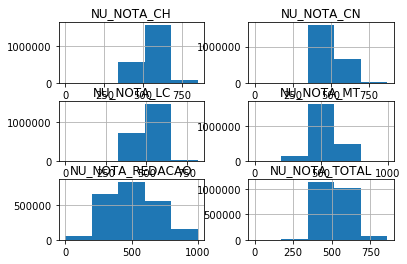

In [15]:
data[['NU_NOTA_REDACAO','NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT','NU_NOTA_TOTAL']].hist(bins=5)
    

In [16]:

one_hot_cols = one_hot_socio+one_hot_escola+one_hot_loc_prova+one_hot_participante+one_hot_prova

df_inp = pandas.get_dummies(data[set(input_cols).intersection(data.columns)], 
                   columns=set(one_hot_cols).intersection(set(input_cols)).intersection(set(data.columns))
           ).replace({**encode_participante, **encode_socio})

#df_out = data[output_cols]
df_out = pandas.get_dummies(data['NU_NOTA_TOTAL'].apply(encode_nota_2))
   

In [ ]:
df_out

# MLP

In [20]:
from pandas.plotting import scatter_matrix
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, roc_auc_score, classification_report

from keras.models import Sequential
from keras.utils import np_utils
from keras.regularizers import l1_l2
from keras.layers.core import Dense, Activation, Dropout
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split, GridSearchCV


In [21]:
df_inp_train, df_inp_test, df_out_train, df_out_test = \
    train_test_split(df_inp,df_out, test_size=0.25, random_state=1)

df_inp_train, df_inp_val, df_out_train, df_out_val = \
    train_test_split(df_inp_train, df_out_train, test_size=0.20, random_state=1)

for col in df_inp.columns:
    if df_inp[col].dtype != 'uint8' and df_inp[col].dtype != 'int64':
        print(col, df_inp[col].dtype)
        
'Train', df_inp_train.shape, df_out_train.shape    

('Train', (1348349, 5591), (1348349, 3))

('Train', (639657, 387), (639657, 3))

In [25]:
def get_model(neurons=30, kernel_initializer='uniform'):
    model = Sequential()
    # model.add(Dense(neuron_num, input_dim=2, activity_regularizer=l1_l2(0.01, 0.01)))

    # Camada Entrada
    model.add(Dense(neurons, input_dim=df_inp_train.shape[1], kernel_initializer=kernel_initializer))
    model.add(Activation('relu'))
 
    model.add(Dense(neurons, kernel_initializer=kernel_initializer))
    model.add(Activation('relu'))
  
    # Camada Saída
    model.add(Dense(df_out_train.shape[1], kernel_initializer=kernel_initializer))
    model.add(Activation('sigmoid'))
    return model


### Test Neuron Numbers on 3 layer network

In [ ]:
df_inp_train, df_inp_test, df_out_train, df_out_test = \
    train_test_split(df_inp,df_out, test_size=0.25, random_state=1)

df_inp_train, df_inp_val, df_out_train, df_out_val = \
    train_test_split(df_inp_train, df_out_train, test_size=0.20, random_state=1)

for col in df_inp.columns:
    if df_inp[col].dtype != 'uint8' and df_inp[col].dtype != 'int64':
        print(col, df_inp[col].dtype)
        
'Train', df_inp_train.shape, df_out_train.shape  

In [28]:
# create model 
keras_model = KerasClassifier(build_fn=get_model, epochs=50, batch_size=50, verbose=0)
# define the grid search parameters
neurons = [10, 20, 60, 100, 150, 200, 300, 500]
param_grid = dict(neurons=neurons)
grid = GridSearchCV(estimator=keras_model, param_grid=param_grid,
                    verbose=1,n_jobs=-1, cv=5, scoring='f1_macro')
grid_result = grid.fit(df_inp_train, df_out_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  40 | elapsed:  4.3min remaining:  4.3min


TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker. The exit codes of the workers are {SIGKILL(-9)}

In [83]:
callbacks = [
    ModelCheckpoint('mlp-neurons-{}-init-{}'.format(neurons,kernel_initializer),
                    monitor='val_loss', save_best_only=True, verbose=1)
]

# we'll use categorical xent for the loss, and RMSprop as the optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam')
#if os.path.isfile(mlp_weight):
#    model.load_weights(mlp_weight)
print("Training...")
history = model.fit(\
    df_inp_train, df_out_train, validation_data=(df_inp_val, df_out_val),\
    callbacks=callbacks,\
    epochs=50, batch_size=5000, verbose=1, shuffle=True, use_multiprocessing=True)

Training...
Train on 639657 samples, validate on 159915 samples
Epoch 1/50
639657/639657 [==============================] - 15s 24us/step - loss: 0.7617 - val_loss: 0.7331

Epoch 00001: val_loss improved from 0.89742 to 0.73306, saving model to mlp-w
Epoch 2/50
639657/639657 [==============================] - 17s 26us/step - loss: 0.7283 - val_loss: 0.7293

Epoch 00002: val_loss improved from 0.73306 to 0.72931, saving model to mlp-w
Epoch 3/50
639657/639657 [==============================] - 16s 25us/step - loss: 0.7237 - val_loss: 0.7268

Epoch 00003: val_loss improved from 0.72931 to 0.72676, saving model to mlp-w
Epoch 4/50
639657/639657 [==============================] - 16s 26us/step - loss: 0.7209 - val_loss: 0.7291

Epoch 00004: val_loss did not improve from 0.72676
Epoch 5/50
639657/639657 [==============================] - 17s 27us/step - loss: 0.7192 - val_loss: 0.7260

Epoch 00005: val_loss improved from 0.72676 to 0.72597, saving model to mlp-w
Epoch 6/50
639657/639657 [==

KeyboardInterrupt: 

In [ ]:
fig = plt.figure(figsize=(10,5))
plt.grid(color='#919191', linestyle=':', linewidth=1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.grid(True)
plt.legend()
fig.savefig('mlp_history.png', dpi=600)
plt.show()


In [107]:
# 0–caminhada; 1 –subindoescadas; 2 –descendo escadas; 3 –sentado; 4 –em pé; 5 –deitado.
print('TRAIN')
pred = np_utils.to_categorical(model.predict_classes(df_inp_train, verbose=1))
print(classification_report(\
    pred, df_out_train,
    labels=range(5),
    target_names=['A','B','C','D','F']))

print('TEST')
pred = np_utils.to_categorical(model.predict_classes(df_inp_test, verbose=1))
print(classification_report(\
    pred, df_out_test,
    labels=range(5),
    target_names=['A','B','C','D','F']))

TRAIN
639657/639657 [==============================] - 60s 93us/step
              precision    recall  f1-score   support

           A       0.85      0.90      0.87     19424
           B       0.86      0.90      0.88     93305
           C       0.85      0.89      0.87    238645
           D       0.65      0.92      0.76     24237
           F       0.93      0.83      0.88    264046

   micro avg       0.87      0.87      0.87    639657
   macro avg       0.83      0.89      0.85    639657
weighted avg       0.88      0.87      0.87    639657
 samples avg       0.87      0.87      0.87    639657

TEST
266524/266524 [==============================] - 25s 93us/step
              precision    recall  f1-score   support

           A       0.14      0.18      0.16      6721
           B       0.31      0.32      0.31     39649
           C       0.42      0.43      0.42    101842
           D       0.03      0.06      0.04      7276
           F       0.54      0.49      0.51    11

In [46]:
np_utils.to_categorical(pred)

array([[0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,SG_UF_NASCIMENTO,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,...,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,Q026,Q027
8,CE,19.0,M,0.0,3,1,CE,2,0,2,...,A,B,B,A,B,A,A,A,B,A
16,CE,18.0,M,0.0,3,1,CE,2,0,2,...,A,C,B,B,C,A,A,A,B,A
26,PB,18.0,F,0.0,1,1,PB,2,0,2,...,A,B,A,A,D,A,A,B,B,A
29,PI,54.0,F,1.0,3,1,PI,2,0,2,...,A,B,B,A,B,A,A,A,B,A
39,SP,17.0,F,0.0,1,1,SP,2,0,2,...,B,B,B,A,D,B,B,B,B,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5513724,SP,18.0,M,0.0,1,1,PE,2,0,2,...,A,C,A,B,D,B,A,B,B,A
5513730,RJ,18.0,M,0.0,3,1,RJ,2,0,2,...,A,B,B,A,E,A,B,B,B,A
5513736,AM,18.0,M,0.0,3,1,AM,2,0,2,...,A,B,A,A,E,A,B,B,B,A
5513743,AM,20.0,F,0.0,3,1,AM,2,0,2,...,A,A,A,A,B,A,A,B,B,A
